In [1]:
import numpy as np
from skimage.transform import radon
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter, maximum_filter
import cv2


In [8]:
import numpy as np

def gaussian_kernel(squared_norm):
    """Gaussian kernel function g(||x||^2)"""
    return np.exp(-0.5 * squared_norm)

def mean_shift_filter_theoretical(image, hs=8, hr=16, max_iter=10, eps=1e-3):
    """
    Mean-shift filtering following the theoretical formulation.
    
    Args:
        image: np.ndarray, input image (grayscale or color)
        hs: float, spatial bandwidth 
        hr: float, range bandwidth
        max_iter: int, maximum iterations per pixel
        eps: float, convergence threshold
    
    Returns:
        filtered image with same shape as input
    """
    # Convert to float for precise computation
    img = image.astype(np.float64)
    h, w = img.shape[:2]
    #print dimensions
    print(f"Image dimensions: height={h}, width={w}, channels={img.shape[2] if img.ndim == 3 else 1}")
    channels = 1 if img.ndim == 2 else img.shape[2]
    
    # Initialize output
    filtered = np.zeros_like(img)
    
    # Create spatial coordinate arrays
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    #print spatial coordinates
    print(f"Spatial coordinates created with shape: {Y.shape}, {X.shape}")
    
    for i in range(h):
        for j in range(w):
            # Initial feature vector z_1 = (spatial, range)
            if channels == 1:
                z_current = np.array([i, j, img[i, j]], dtype=np.float64)
            else:
                z_current = np.concatenate([[i, j], img[i, j, :]], dtype=np.float64)
            
            # Mean-shift iterations
            for iteration in range(max_iter):
                print(f"Processing pixel ({i}, {j}), iteration {iteration + 1}")
                # Extract current spatial and range components
                z_spatial = z_current[:2]  # (z_s)
                z_range = z_current[2:]    # (z_3) or color channels
                
                # Initialize numerator and denominator for weighted mean
                numerator = np.zeros_like(z_current)
                denominator = 0.0
                
                 # Replace the double for-loop with a windowed search:
                i_min = max(i - hs, 0)
                i_max = min(i + hs + 1, h)
                j_min = max(j - hs, 0)
                j_max = min(j + hs + 1, w)

                # Iterate over all pixels in the image
                #for pi in range(h):
                #    for pj in range(w):
                for pi in range(i_min, i_max):
                    for pj in range(j_min, j_max):
                        # Pixel spatial position
                        p_spatial = np.array([pi, pj], dtype=np.float64)
                        
                        # Pixel range information
                        if channels == 1:
                            p_range = np.array([img[pi, pj]], dtype=np.float64)
                            p_full = np.concatenate([p_spatial, p_range])
                        else:
                            p_range = img[pi, pj, :].astype(np.float64)
                            p_full = np.concatenate([p_spatial, p_range])
                        
                        # Calculate normalized squared distances
                        spatial_dist_sq = np.sum((z_spatial - p_spatial)**2) / (hs**2)
                        range_dist_sq = np.sum((z_range - p_range)**2) / (hr**2)
                        
                        # Apply Gaussian kernels
                        spatial_kernel = gaussian_kernel(spatial_dist_sq)
                        range_kernel = gaussian_kernel(range_dist_sq)
                        
                        # Combined weight
                        weight = spatial_kernel * range_kernel
                        
                        # Accumulate weighted sum
                        numerator += weight * p_full
                        denominator += weight
                
                # Calculate new mean-shift vector
                if denominator > 1e-10:  # Avoid division by zero
                    z_new = numerator / denominator
                else:
                    z_new = z_current
                
                # Calculate shift magnitude (difference between iterations)
                diff = z_new - z_current
                shift_magnitude = np.linalg.norm(diff)
                
                # Update current position
                z_current = z_new
                
                # Check convergence
                if shift_magnitude < eps:
                    break
            
            # Assign converged range value to output
            if channels == 1:
                filtered[i, j] = z_current[2]
            else:
                filtered[i, j, :] = z_current[2:]
    
    return filtered.astype(image.dtype)



In [11]:
# Usage:
img= cv2.imread('44.jpg', cv2.IMREAD_GRAYSCALE)
result = mean_shift_filter_theoretical(img, hs=24, hr=40, max_iter=10, eps=1e-3)


Image dimensions: height=789, width=1086, channels=1
Spatial coordinates created with shape: (789, 1086), (789, 1086)
Processing pixel (0, 0), iteration 1
Processing pixel (0, 0), iteration 2
Processing pixel (0, 0), iteration 3
Processing pixel (0, 0), iteration 4
Processing pixel (0, 0), iteration 5
Processing pixel (0, 1), iteration 1
Processing pixel (0, 1), iteration 2
Processing pixel (0, 1), iteration 3
Processing pixel (0, 1), iteration 4
Processing pixel (0, 1), iteration 5
Processing pixel (0, 1), iteration 6
Processing pixel (0, 2), iteration 1
Processing pixel (0, 2), iteration 2
Processing pixel (0, 2), iteration 3
Processing pixel (0, 2), iteration 4
Processing pixel (0, 2), iteration 5
Processing pixel (0, 2), iteration 6
Processing pixel (0, 3), iteration 1
Processing pixel (0, 3), iteration 2
Processing pixel (0, 3), iteration 3
Processing pixel (0, 3), iteration 4
Processing pixel (0, 3), iteration 5
Processing pixel (0, 3), iteration 6
Processing pixel (0, 4), iterat

KeyboardInterrupt: 

In [24]:
# Usage:
def mean_shift_filtering_approx(img, sp=8, sr=16):
    #img = cv2.imread('44.jpg', cv2.IMREAD_GRAYSCALE)
    # Convert grayscale to BGR for pyrMeanShiftFiltering
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # Apply OpenCV's fast mean shift filtering
    result_bgr = cv2.pyrMeanShiftFiltering(img_bgr, sp=sp, sr=sr)
    # Convert back to grayscale if needed
    result = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2GRAY)
    return result

In [31]:
img= cv2.imread('44.jpg', cv2.IMREAD_GRAYSCALE)
result = mean_shift_filtering_approx(img, sp=8, sr=16)

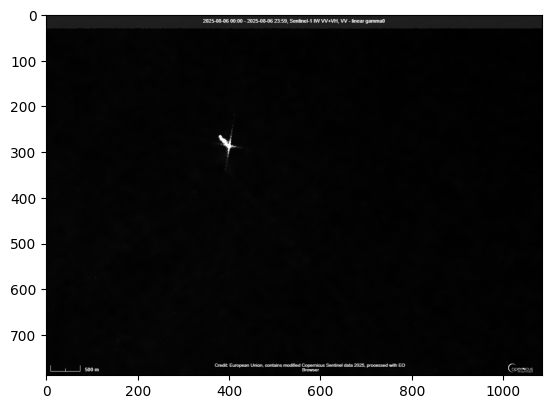

In [40]:
import matplotlib.pyplot as plt


plt.imshow(result, cmap='gray')

#save result
plt.imsave('mean_shift_result.png', result, cmap='gray')

In [41]:
# Step 2: Normalization
def normalize_image(img):
    J_t = np.mean(img)
    u = np.std(img)
    f = (img - J_t) / u
    return f

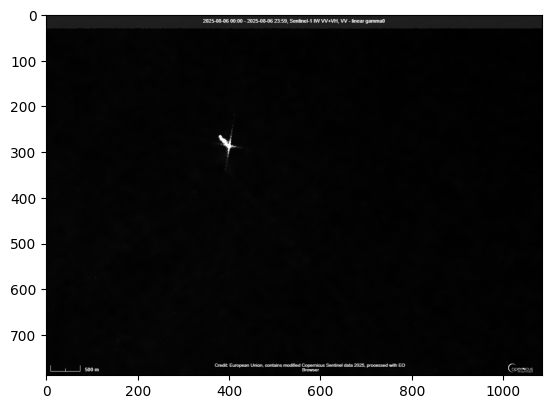

In [42]:
result_normalized = normalize_image(result.astype(np.float32))

plt.imshow(result_normalized, cmap='gray')
#save normalized result
plt.imsave('mean_shift_result_normalized.png', result_normalized, cmap='gray')

In [80]:
def unsharp_mask(image, sigma, strength):
    # Blur the image using Gaussian filter
    blurred = gaussian_filter(image, sigma=sigma)
    # Calculate the mask (difference between original and blurred)
    mask = image - blurred
    # Add the mask back to original image to enhance edges
    enhanced = image + strength * mask
    # Clip values to valid range and return
    enhanced = np.clip(enhanced, 0, 255)
    return enhanced.astype(np.uint8)


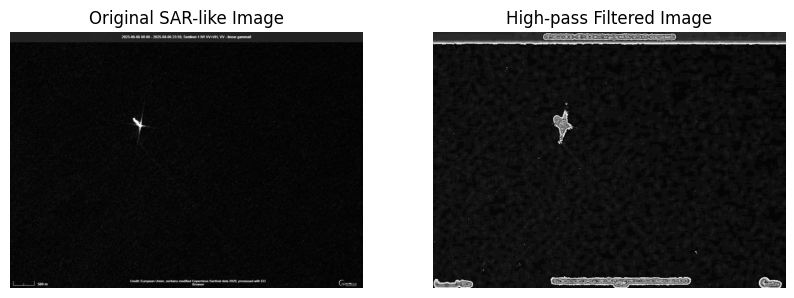

In [99]:

filtered_image =unsharp_mask(result, sigma=4, strength=8)

# Display original and filtered images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original SAR-like Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('High-pass Filtered Image')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()


In [86]:
#save filtered image
plt.imsave('high_pass_filtered_image.png', filtered_image, cmap='gray')

(np.float64(-0.5), np.float64(1085.5), np.float64(788.5), np.float64(-0.5))

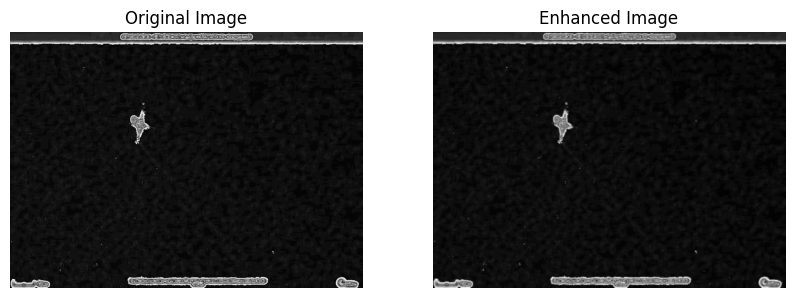

In [104]:
from scipy.ndimage import convolve

def adaptive_line_enhancer_2d(image, filter_size=3, mu=0.01, iterations=5):
    # Initialize output image as float for processing
    output = image.copy().astype(np.float64)
    
    # Define directional kernels for line enhancement: horizontal, vertical, diagonal \ and diagonal /
    kernels = [
        np.array([[0,0,0], [1,-1,0], [0,0,0]]),  # horizontal
        np.array([[0,1,0], [0,-1,0], [0,0,0]]),  # vertical
        np.array([[1,0,0], [0,-1,0], [0,0,0]]),  # diagonal \
        np.array([[0,0,1], [0,-1,0], [0,0,0]])   # diagonal /
    ]
    
    # Equal initial weights for each directional filter
    weights = np.ones(len(kernels), dtype=np.float64) / len(kernels)
    
    for _ in range(iterations):
        response = np.zeros_like(output)
        # Apply each directional kernel
        filtered_images = [convolve(output, k, mode='reflect') for k in kernels]
        
        # Compute magnitudes and local weights to emphasize stronger responses
        magnitudes = np.array([np.abs(f) for f in filtered_images])
        sums = np.sum(magnitudes, axis=0) + 1e-10  # avoid division by zero
        local_weights = magnitudes / sums
        
        # Weighted sum of directional responses
        for i, w in enumerate(local_weights):
            response += w * filtered_images[i]
        
        # Update the output image adaptively
        output += mu * response
        # Clamp to valid grayscale range
        output = np.clip(output, 0, 255)
    
    return output.astype(np.uint8)


# Apply the adaptive line enhancer
enhanced_img = adaptive_line_enhancer_2d(filtered_image, filter_size=3, mu=0.1, iterations=10)

# Visualize original and enhanced images side by side
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off') 
plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(enhanced_img, cmap='gray')
plt.axis('off')



In [93]:
# Step 3: Localized Radon transform (Corrected)
def localized_radon(image, window_size=100, overlap=50, theta=None):
    """
    Implement localized Radon transform as described in the theory.
    
    Parameters:
    - image: Input grayscale image
    - window_size: Size of the sliding window (should be small enough to detect 
                   lines of desired length)
    - overlap: Overlap between adjacent windows (should provide good coverage)
    - theta: Projection angles in degrees (0 to 180)
    """
    if theta is None:
        # Use angles from 0 to 180 degrees (not including 180 to avoid redundancy)
        theta = np.linspace(0., 180., 180, endpoint=False)
    
    h, w = image.shape
    radon_coeffs = []
    positions = []
    
    # Calculate step size ensuring proper overlap
    step = max(1, window_size - overlap)  # Ensure minimum step of 1
    
    # Sliding window approach with proper boundary handling
    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            # Extract window from image
            window = image[y:y + window_size, x:x + window_size]
            
            # Apply Radon transform to the window
            # Using circle=True for proper geometric interpretation
            radon_trans = radon(window, theta=theta, circle=True)
            
            radon_coeffs.append(radon_trans)
            
            # Store center position of the window for proper localization
            center_x = x + window_size // 2
            center_y = y + window_size // 2
            positions.append((center_x, center_y))
    
    return radon_coeffs, positions, theta



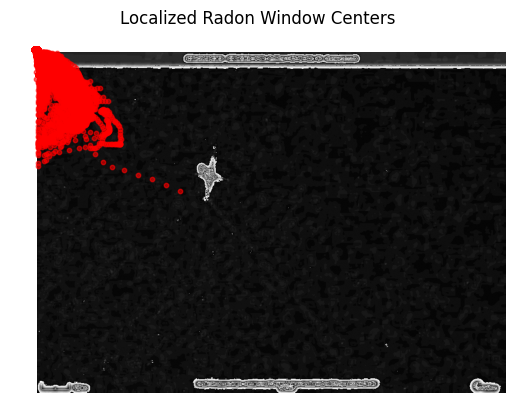

In [ ]:


# Plot the local window and its Radon transform sinogram
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Local Window')
plt.imshow(local_window, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Localized Radon Transform (Sinogram)')
plt.imshow(sinogram, extent=(theta[0], theta[-1], 0, sinogram.shape[0]), aspect='auto', cmap='gray')
plt.xlabel('Angle (degrees)')
plt.ylabel('Radon Projection')

plt.show()


In [16]:
def detect_local_features_adaptive(radon_coeffs, positions, M=3, N=2, window_size=5):
    """
    Locally adaptive detection algorithm for peaks in Radon transform space.
    Based on local mean and standard deviation statistics.
    
    Parameters:
    - M, N: User-defined parameters for threshold calculation
    - window_size: Size of local window for statistics computation
    """
    detected_features = []
    
    for idx, (radon_coeff, pos) in enumerate(zip(radon_coeffs, positions)):
        h, w = radon_coeff.shape
        
        # Create padded version for boundary handling
        pad_size = window_size // 2
        padded_coeff = np.pad(radon_coeff, pad_size, mode='reflect')
        
        # Apply locally adaptive threshold
        for i in range(h):
            for j in range(w):
                # Extract local window
                local_window = padded_coeff[i:i+window_size, j:j+window_size]
                
                # Calculate local statistics
                local_mean = np.mean(local_window)
                local_std = np.std(local_window)
                
                # Adaptive threshold: M × μ + N × σ
                adaptive_threshold = M * local_mean + N * local_std
                
                # Check if current pixel exceeds adaptive threshold
                if radon_coeff[i, j] > adaptive_threshold:
                    detected_features.append({
                        'window_center': pos,
                        'window_index': idx,
                        'rho_index': i,
                        'theta_index': j,
                        'transform_value': radon_coeff[i, j],
                        'local_threshold': adaptive_threshold,
                        'local_mean': local_mean,
                        'local_std': local_std
                    })
    
    return detected_features


c:\Users\Utente\Desktop\Vision\prog\.conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


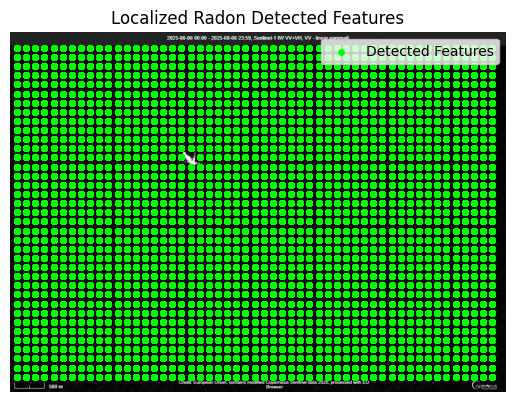

In [38]:
detected_features = detect_local_features_adaptive(radon_coeffs, positions, M=3, N=2, window_size=5)
# Get positions of windows with detected features
feature_positions = [feature['window_center'] for feature in detected_features]

# Convert to array for plotting
feature_positions = np.array(feature_positions)

# Plot the original image with detected feature locations
plt.imshow(img, cmap='gray')
if len(feature_positions) > 0:
    plt.scatter(feature_positions[:, 0], feature_positions[:, 1], color='lime', s=15, label='Detected Features')
plt.title("Localized Radon Detected Features")
plt.axis('off')
plt.legend()
plt.show()

In [17]:
import numpy as np

def shannon_entropy(x):
    """
    Compute Shannon entropy for ship wake detection.
    
    Parameters:
    x: array of gray levels of the original image pixels for the considered feature
    
    Returns:
    entropy: Shannon entropy value
    """
    x = np.array(x, dtype=float)
    
    # Use square of x values as shown in the formula
    x_squared = x ** 2
    
    # Normalize to create a probability distribution that sums to 1
    x_norm = x_squared / np.sum(x_squared)
    
    # Filter out zero values to avoid log(0) issues
    x_norm = x_norm[x_norm > 0]
    
    # Compute entropy: -sum(x_i^2 * log(x_i^2))
    entropy = -np.sum(x_norm * np.log(x_norm))
    
    return entropy


In [29]:

# Main pipeline
def enhance_ship_wakes_sar(image, M=1.5, N=1.0):
    filtered = mean_shift_filtering_approx(image)
    print("image filtered")
    norm_img = normalize_image(filtered.astype(np.float32))
    print("image normalized")
    radon_coeffs, positions, theta = localized_radon(norm_img)
    print("radon coefficients computed")
    # Use adaptive peak detection
    print("detecting local features")
    detected_peaks = detect_local_features_adaptive(radon_coeffs,positions, M=M, N=N, window_size=5)
    print("local features detected")
    true_wakes = []
    for idx, peaks in enumerate(detected_peaks):
        x, y = positions[idx]
        window = image[y:y + 100, x:x + 100]
        peaks_filtered = []
        for r, c in zip(peaks[0], peaks[1]):
            if r < window.shape[0] and c < window.shape[1]:
                gray_vals = window[:, c]
                ent = shannon_entropy(gray_vals)
                if ent < 4.0:  # Threshold to be tuned
                    peaks_filtered.append((r, c))
        true_wakes.append(peaks_filtered)
    print("true wakes detected")
    return true_wakes


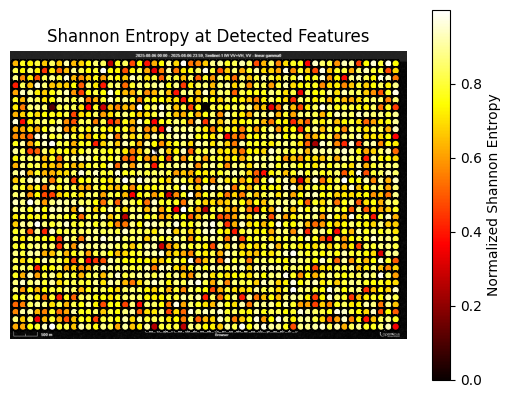

In [39]:
import matplotlib.pyplot as plt

# Compute entropy for each detected feature using a patch from the original image
entropies = []
for feature in detected_features:
    x_center, y_center = feature['window_center']
    
    # Extract a small patch around the feature location from the original image
    patch_size = 5  # You can adjust this
    half = patch_size // 2
    y_start = max(0, y_center - half)
    y_end = min(img.shape[0], y_center + half + 1)
    x_start = max(0, x_center - half)
    x_end = min(img.shape[1], x_center + half + 1)
    
    patch = img[y_start:y_end, x_start:x_end]
    
    # Compute entropy of the patch
    entropy = shannon_entropy(patch.flatten())
    entropies.append(entropy)

# Normalize entropies for visualization (e.g., to scale point sizes or color)
entropies = np.array(entropies)
norm_entropies = (entropies - np.min(entropies)) / (np.ptp(entropies) + 1e-8)

# Get feature positions
positions = np.array([f['window_center'] for f in detected_features])

# Plot the original image with entropy values visualized
plt.imshow(img, cmap='gray')
sc = plt.scatter(positions[:, 0], positions[:, 1], c=norm_entropies, cmap='hot', s=30, edgecolors='black')
plt.colorbar(sc, label='Normalized Shannon Entropy')
plt.title("Shannon Entropy at Detected Features")
plt.axis('off')
plt.show()


In [ ]:

# Usage:
img= cv2.imread('44.jpg', cv2.IMREAD_GRAYSCALE)
result = enhance_ship_wakes_sar(img)



image filtered
image normalized


c:\Users\Utente\Desktop\Vision\prog\.conda\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


radon coefficients computed
detecting local features
local features detected


KeyError: 0

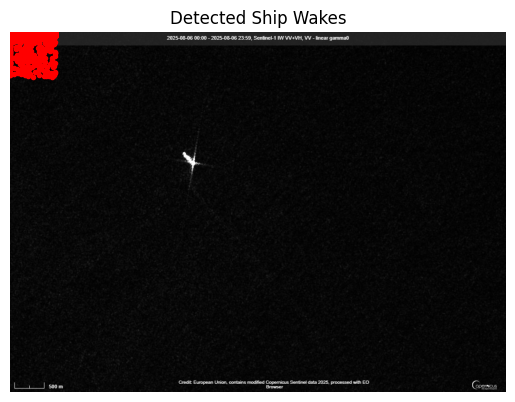

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
for wake_list in result:
    for r, c in wake_list:
        plt.plot(c, r, 'ro', markersize=3)
plt.title('Detected Ship Wakes')
plt.axis('off')
plt.show()